In [1]:
using DataFrames, StatsBase, CategoricalArrays
using Random: Xoshiro

const seed=1234
const rng=Xoshiro(seed)
const simpath = "simulations"
const figpath = "figures"
const tabpath = "tables"
for i in [simpath, figpath, tabpath]
    if !ispath(i); mkdir(i); end
end

In [2]:
include("src/LoadUtils.jl")

Main.LoadUtils

In [3]:
# config
M = 10
λ = .9
conditionorder = ("no influence", "few", "even", "biased", "shifted")
artefacts_distributions = ([], LinRange(0,1,3), LinRange(0,1,M),- .1 .^collect(range(0, stop=1, length=M)) .+ 1.1,LinRange(0.5,1,Int(M/2)))
conditions = Dict(conditionorder .=> artefacts_distributions)
graphfilename="graph_edges.csv"
fname = simpath

"simulations"

In [22]:
LoadUtils.write_artefact_epsilons(R, N, λ; epsilons=.05:.01:.3, rng, fname, conditionorder, conditions, iteration_steps=200, check_every=50, tol=1e-07)

n = "no influence"
n = "even"
n = "few"
n = "shifted"
n = "biased"
../simulations/nondirected_graph/epsilon=0.1.csv converged after ["no influence" => -1, "even" => 200, "few" => 250, "shifted" => -1, "initial" => 0, "biased" => 200]n = "no influence"
n = "even"
n = "few"
n = "shifted"
n = "biased"
../simulations/nondirected_graph/epsilon=0.15.csv converged after ["no influence" => -1, "even" => 200, "few" => -1, "shifted" => -1, "initial" => 0, "biased" => 250]n = "no influence"
n = "even"
n = "few"
n = "shifted"
n = "biased"
../simulations/nondirected_graph/epsilon=0.3.csv converged after ["no influence" => 200, "even" => 150, "few" => 300, "shifted" => 150, "initial" => 0, "biased" => 150]

In [4]:
# Latex table Setup
using HypothesisTests, Formatting, PrettyTables, Distributions

function chopformatter(v, i, j; chopleadingzerocols=nothing, colformats=[[1]=>"%.2f", pvalcolnrs=>"%.3f", uvalcolnrs=>"%d"])
    isnothing(v) && return "" 
    v isa Real && v < .001 && return "< .001"
    res = v
    fmtidx = findfirst(cols-> j ∈ cols, first.(colformats))
    if !isnothing(fmtidx); res = sprintf1(last(colformats[fmtidx]), v); end
    if j ∈ chopleadingzerocols; res = chopprefix(string.(res), "0"); end
    res
end

tf=LatexTableFormat(
    top_line="\\toprule",
    header_line="\\midrule",
    bottom_line="\\bottomrule",
    left_vline     = "",
    mid_vline      = "",
    right_vline    = "",
    header_envs=[], subheader_envs=[],
)

LatexTableFormat("\\toprule", "\\midrule", "\\hline", "\\bottomrule", "", "", "", String[], String[], [:begin, :header, :end], :none, :tabular, true, "table")

In [5]:
# Makie setup
using CairoMakie
scattermarker(c, marker = :circle) = MarkerElement(color=c,marker=marker)
romanenum = ["(i)", "(ii)", "(iii)", "(iv)", "(v)", "(vi)", "(vii)"];
function condition_legend!(fig_position, from=1, to=length(conditions); 
    colors=Makie.wong_colors(), conditionlabels=join.(zip(romanenum[from:to], conditionorder[from:to]), " "), 
    legendargs = (orientation = :horizontal, tellwidth = false, tellheight = true, framevisible=false)
)
    Legend(fig_position, map(i->LineElement(color=i), colors[from:to]), conditionlabels; legendargs...)
end

condition_legend! (generic function with 3 methods)

# Analysis

In [8]:
# loading results
adf=LoadUtils.load_adf(; e=.05:.01:.3, path=fname);

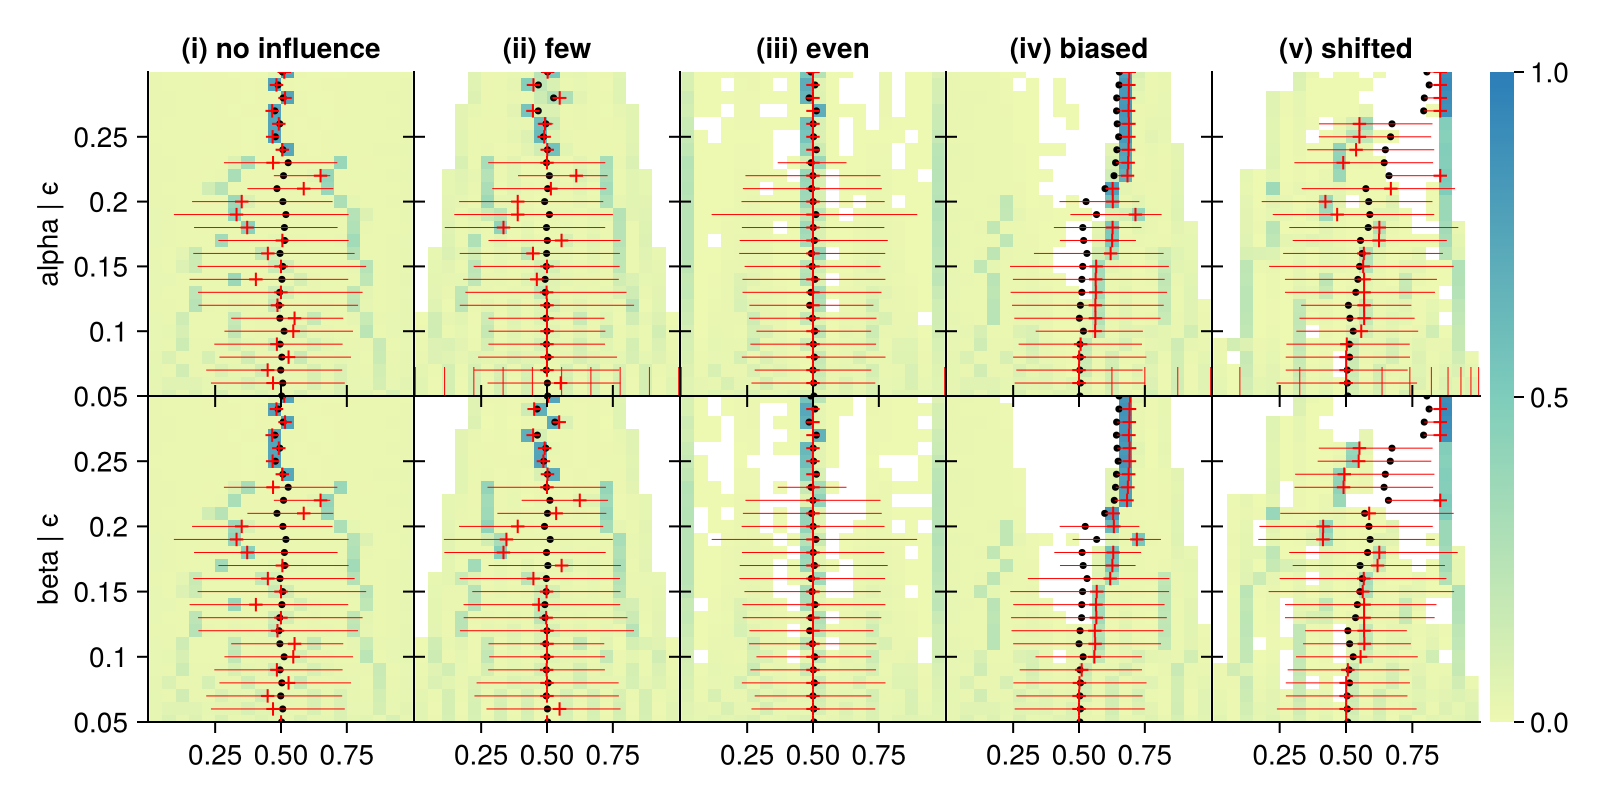

In [9]:
# epsilon -- alpha/beta heatmap
function simheatmap!(
    df;
    conditionorder=conditionorder,
    conditions = conditions,
    epsilons=unique(df.epsilon),
    xticks = (epsilons, string.(epsilons)),
    artefact_color=:black,
    axargs = (
        xgridvisible=false, ygridvisible=false, topspinevisible=false, rightspinevisible=false,
        xminorticksize=15, xminortickwidth=.5, xminortickalign=1, xminortickcolor=:red),
    bins=0:.05:1,
    N=combine(groupby(df, [:condition, :epsilon]), nrow)[1, :nrow],
    heatmapargs = (colorrange=(0,1), colormap = :YlGnBu_3),
    fig = Figure(size=(800, 400)),
    position=(:,:)
)

    df = @view(df[df.condition .∈ Ref(conditionorder) .&& df.epsilon .∈ Ref(epsilons), :])
    xlayout = GridLayout(fig[:, :])
    
    
    axes = Array{Any}(undef, 2, length(conditionorder))
    
    xticks=.25:.25:.75
    limits=(-0.005,1.005, minimum(epsilons), maximum(epsilons))
    dfm = combine(groupby(df, [:condition, :epsilon]), [:alpha, :beta] .=> mean, [:alpha, :beta] .=> iqr, [:alpha, :beta] .=> median) 

    for (i, x) in enumerate([:alpha, :beta])
        df.bins = cut(df[:, x], bins, extend=true, labels=round.(bins[1:end-1] .+ .025, digits=3))
        dft = combine(groupby(df, [:condition, :epsilon, :bins]), nrow)
        yticks=(epsilons[1:5:end-i], string.(epsilons[1:5:end-i]))
        for (j, (c, a)) in enumerate(conditions)
            axes[i,j] = ax = Axis(
                xlayout[i, j]; limits, xticks, yticks,  axargs..., xticksmirrored=i>1, yticksmirrored=j<length(conditions),
                ifelse(isempty(a) || i > 1, (), (xminorticksvisible=true, xminorticks=a))...)
            dftv = @view dft[dft.condition .== c, :]
            hm = heatmap!(ax, convert.(Float64, dftv.bins), dftv.epsilon, dftv.nrow ./ N; heatmapargs...)

            dfmv = @view dfm[dfm.condition .== c,:]
            scatter!(ax, dfmv[:, Symbol(x,"_mean")], dfmv.epsilon; color=:black, markersize=5)
            scatter!(ax, dfmv[:, Symbol(x,"_median")], dfmv.epsilon; color=:red, marker='+', markersize=15)
            rangebars!(ax, dfmv.epsilon, dfmv[:, Symbol(x,"_median")] .- dfmv[:, Symbol(x,"_iqr")]./2, dfmv[:, Symbol(x,"_mean")] .+ dfmv[:, Symbol(x,"_iqr")]./2, color = :red, direction=:x, linewidth=.5)
        end
    end

    for ax in axes[:, 2:end]; ax.yticklabelsvisible=false; end
    for (ax, x) in zip(axes[:, 1], ("alpha", "beta")); ax.ylabel="$x | ϵ"; end
    for (ax, title, i) in zip(axes[1, :], conditionorder, romanenum)
        ax.xticklabelsvisible=false
        ax.title= "$(i) $(title)"
    end

    Colorbar(fig[:, end+1]; spinewidth=0, heatmapargs...)
    colsize!(xlayout, 1, Relative(1/length(conditions)))
    rowgap!(xlayout, -5)
    colgap!(xlayout, -5)
    colgap!(fig.layout, 5)
    fig
end
fig = simheatmap!(adf)
save(joinpath(figpath,"heatmap.png"), fig)
fig

## Occupied space, variance

In [10]:
# FK tests
function fktest(c, x, conditionorder=conditionorder)
    fktest = FlignerKilleenTest(map(cc -> x[c.== cc], conditionorder)...)
    HypothesisTests.teststatistic(fktest), pvalue(fktest)
end

fk = combine(
    groupby(adf, :epsilon), 
    [:condition, :alpha, :beta] => ((c,a,b) -> [[fktest(c,a)..., fktest(c,b)...]]) => ["alpha statistic", "alpha p-value", "beta statistic", "beta p-value"])

Row,epsilon,alpha statistic,alpha p-value,beta statistic,beta p-value
,Float64,Float64,Float64,Float64,Float64
1,0.05,52.2022,1.25145e-10,49.4605,4.67996e-10
2,0.06,57.1835,1.13222e-11,59.9257,3.007e-12
3,0.07,117.17,2.14764e-24,139.576,3.47905e-29
4,0.08,278.541,4.59736e-59,251.852,2.59708e-53
5,0.09,450.955,2.70064e-96,450.153,4.02477e-96
6,0.1,243.955,1.30515e-51,239.628,1.11573e-50
7,0.11,430.859,5.96248e-92,425.097,1.04895e-90
8,0.12,678.112,1.91126e-145,693.597,8.48711e-149
9,0.13,1342.8,1.74561e-289,1319.88,1.63193e-284


In [11]:
# occupied space 
function occupied_space(a; bins=0:.01:1)
    xbins = unwrap.(cut(a, bins, extend=true, labels=bins[1:end-1]))
    sum(bins .∈ Ref(xbins)) / (length(bins)-1)
end

statsdf = combine(
    groupby(adf, [:condition, :epsilon]), 
    [:alpha, :beta] => ((a,b) -> begin
        x = hcat(a,b)
        (occupied=occupied_space(x), mean=mean(x), std=std(x))
    end) => AsTable);

In [12]:
statsjoind = innerjoin(groupby(statsdf[statsdf.condition .∈ Ref(conditionorder), :], :condition)...; on=:epsilon, makeunique=true)[:, Not(r"condition")];
statsjoind=statsjoind[:, Not(r"condition")]
n = size(statsjoind,2)
meanstdcolnrs = findall(x->occursin(r"mean|std", x), names(statsjoind))

open(joinpath(tabpath, "stats.tex"), "a") do io
    pretty_table(
        io,
        statsjoind;
        backend = Val(:latex), tf, wrap_table=false, 
        formatters = (v,i,j) -> chopformatter(
            v,i,j; 
            chopleadingzerocols=filter(∉(meanstdcolnrs), 1:n), 
            colformats=[filter(∉(meanstdcolnrs), 1:n)=>"%.2f", meanstdcolnrs=>"%.3f"]))
end

## Distributions

Testing normality using Jarque Bera

In [13]:
# JB normality 
using Distributions
jbdf = combine(groupby(adf, [:epsilon, :condition]),  [:alpha, :beta] .=> (a-> JarqueBeraTest(a).JB));

In [14]:
jbdfpvals = combine(groupby(adf, [:epsilon, :condition]),  [:alpha, :beta] .=> (a-> pvalue(JarqueBeraTest(a))))
jbdfpvals[jbdfpvals[:, 3] .> .001 .|| jbdfpvals[:, 4] .> .001 ,:]

Row,epsilon,condition,alpha_function,beta_function
,Float64,String,Float64,Float64
1,0.26,few,0.00216895,0.00132014


In [15]:
# JB to latex
jbdflong = innerjoin(groupby(unstack(stack(jbdf, [:alpha_function, :beta_function]) ,:condition, :value), :variable)..., on = :epsilon, renamecols = "_α" => "_β")[:, Not(r"variable|initial")]

n = size(jbdflong,2)
chopleadingzerocols=[1]

open(joinpath(tabpath, "normality.tex"), "a") do io
    pretty_table(
        io,
        jbdflong; 
        backend = Val(:latex), tf, wrap_table=false,
        formatters = ((v,i,j) ->
        chopformatter(v,i,j; chopleadingzerocols=(1,), colformats=[(1,)=>"%.2f", 2:n=>"%d"])))
end

Using Anderson Darling

In [16]:
ad = combine(
    groupby(adf, [:epsilon, :condition]),  
    [:alpha, :beta] .=> (a -> begin
    res = OneSampleADTest(a, Normal(.5)) 
    (A=res.A², p=pvalue(res))
end) .=> i->i.*[" A²", " p-value"])

Row,epsilon,condition,alpha A²,alpha p-value,beta A²,beta p-value
,Float64,String,Float64,Float64,Float64,Float64
1,0.05,initial,1699.69,6.0e-8,1722.53,6.0e-8
2,0.05,no influence,1709.88,6.0e-8,1709.88,6.0e-8
3,0.05,few,1674.08,6.0e-8,1674.08,6.0e-8
4,0.05,even,1695.08,6.0e-8,1694.81,6.0e-8
5,0.05,biased,1690.84,6.0e-8,1691.5,6.0e-8
6,0.05,shifted,1698.6,6.0e-8,1698.42,6.0e-8
7,0.06,initial,1717.01,6.0e-8,1720.86,6.0e-8
8,0.06,no influence,1748.42,6.0e-8,1748.42,6.0e-8
9,0.06,few,1697.58,6.0e-8,1697.77,6.0e-8


Testing difference/sameness of distributions using Mann-Whitney U since neither alpha nor beta are normally distributed.

In [17]:
# MWU tests
headers = reduce(vcat, Symbol.(Ref(c), [" U", " two-tailed", " left-tailed"]) for c in conditionorder[2:end])

mwu = combine(
    groupby(adf, :epsilon), 
    [:condition, :alpha] => ((c,a) -> begin
        anoinfl = a[c .== first(conditionorder)]
        grps = [a[c.== cc] for cc in conditionorder[2:end]]
        [reduce(vcat, MannWhitneyUTest.(Ref(anoinfl), grps) .|> i-> [i.U, pvalue(i), pvalue(i, tail=:left)])]
    end) => headers
);

In [18]:
# MWU to latex
mwun = mwu[:, Not("few left-tailed", "even left-tailed")]
pvalcolnrs = findall(i->occursin("tailed", i), names(mwun))
uvalcolnrs = findall(i->occursin("U", i), names(mwun))

open(joinpath(tabpath, "mwu.tex"), "a") do io
pretty_table(
    io,
    mwun; 
    backend = Val(:latex), tf, wrap_table=false, 
    formatters = (v,i,j) -> chopformatter(v,i,j; chopleadingzerocols=vcat(1,pvalcolnrs), colformats=[(1,)=>"%.2f", pvalcolnrs => "%.3f", uvalcolnrs=>"%d"]), 
    highlighters = LatexHighlighter((data, i, j) -> data[i, j] isa Real && data[i, j] .< .05, ["textbf"]))
end

## Ripley's K/L/H

In [19]:
# ripley's L
using Distances
        
area(args...) = abs(reduce(*, map(i-> sum(i.* [-1,1]), extrema.(args))))

function ripleyk!(α, β, radii; n = length(α), dmat = zeros(n,n), k = zeros(Int, length(radii)), dist)
    dmat .= pairwise(dist, zip(α, β), zip(α, β))
    for j in 1:n, i in 1:j-1
        k .+= radii .> dmat[i,j]
    end
    k .= k.*2 ./ n^2 * area(α, β)
end

function ripleyl!(α, β, radii; n = length(α), dmat = zeros(n,n), k = zeros(length(radii)), dist=euclidean, linearized=true)
    ripleyk!(α, β, radii; n, dmat, k, dist=euclidean)
    k .= sqrt.(k ./π)
    linearized && k .= k .- radii
    k
end

radii = 0:.01:.5
n = length(@view(adf[adf.condition .== first(adf.condition) .&& adf.epsilon .== first(adf.epsilon), 1]))
dmat = zeros(n,n);
ripleyldf = combine(groupby(adf[adf.epsilon .∈ Ref([.1, .15, .3]), :], [:condition, :epsilon]), [:alpha, :beta] => ((α, β) -> [ripleyl!(α, β, radii; n, dmat)]) => string.(radii));

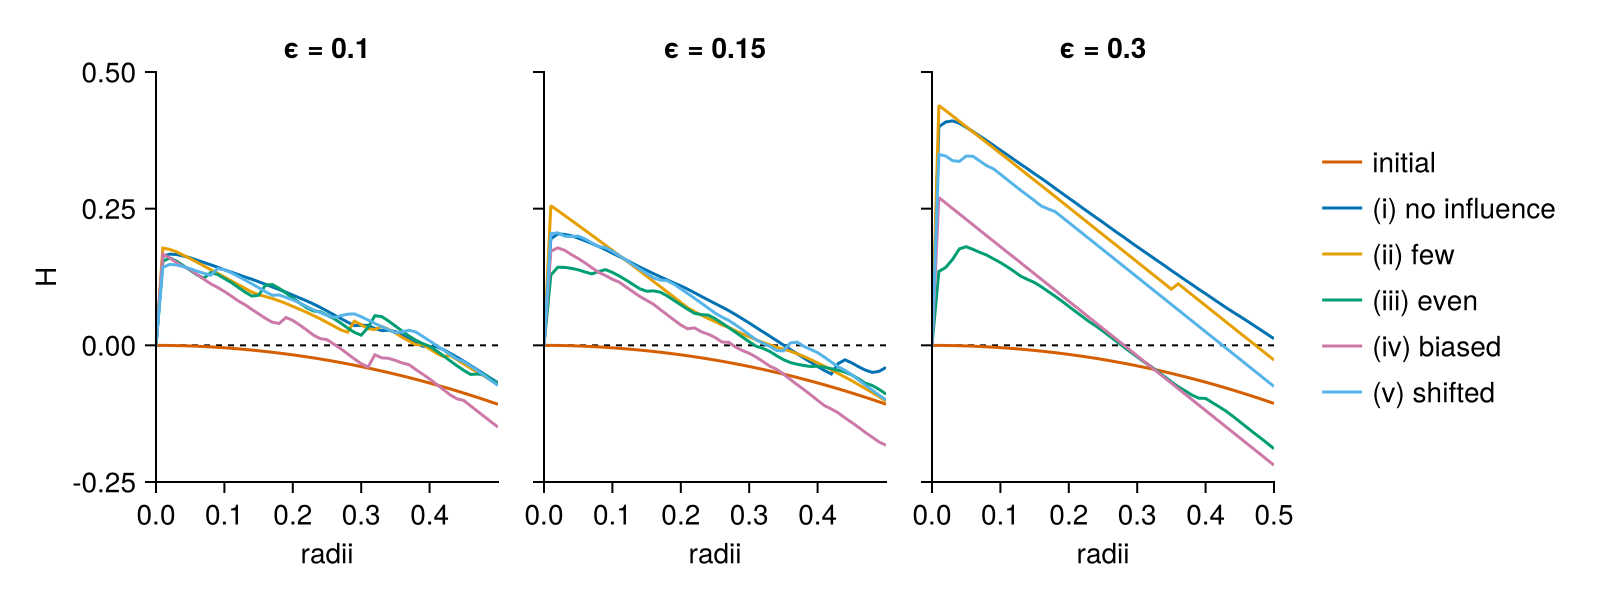

In [20]:
# ripley's l plot
function ripley_plot!(
    ripleyldf, epsilons=[.1, .15, .3], conditionorder=conditionorder;
    fig = Figure(size=(800, 300), title="Ripley's L"),
    colors=Makie.wong_colors(),
    axargs = (e, epsilons=epsilons) -> (
        xgridvisible=false, ygridvisible=false, topspinevisible=false, rightspinevisible=false,
        ytickformat="{:.2f}", xtickformat="{:.1f}", 
        title="ϵ = $e",
        xlabel="radii",
        ylabel=ifelse(e==first(epsilons), "H", ""),
        yticks = -.5:.25:.5, xticks=radii[1:10:end-Int(e!=last(epsilons))],
        yticklabelsvisible=e==first(epsilons),
        limits=(extrema(radii), (-.25, .5))
    ))

    for (i,e) in enumerate(epsilons)
        ax = Axis(fig[:,i]; axargs(e, epsilons)...)
        hlines!(ax, 0; color=:black, linestyle=:dash, linewidth=1)
        lines!(ax, radii, Matrix(ripleyldf[ripleyldf.condition .== "initial" .&& ripleyldf.epsilon .== e, 3:end])[1,:], color=colors[length(conditionorder)+1])
        for (c, col) in zip(conditionorder, colors)
            l = Matrix(ripleyldf[ripleyldf.condition .== c .&& ripleyldf.epsilon .== e, 3:end])[1,:]
            lines!(ax, radii, l, color=col)
        end
    end
    rowgap!(fig.layout, 0)
    
    conditionlabels= vcat(["initial"], join.(zip(romanenum, conditionorder), " "))
    elements = map(i->LineElement(color=i), colors[[length(conditions)+1;1:length(conditions)]])
    Legend(fig[:, end+1], elements, conditionlabels; tellwidth = true, tellheight = false, framevisible=false)

    fig
end
fig = ripley_plot!(ripleyldf)
save(joinpath(figpath, "ripley.png"), fig)
fig